In [452]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [453]:
ua_map = cv2.imread('lab_02_pics/ua_map.png')
bing = cv2.imread('lab_02_pics/bing.png')
bing = cv2.cvtColor(bing, cv2.COLOR_BGR2RGB)

In [454]:
def show_image(image, title="_", is_mask=False):
    plt.figure(figsize=(6, 4))
    if is_mask or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

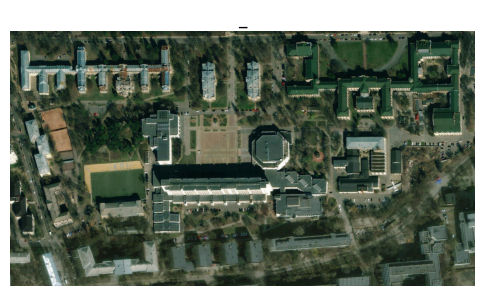

In [455]:
show_image(bing)

In [456]:
lab = cv2.cvtColor(bing, cv2.COLOR_RGB2LAB)
hsv = cv2.cvtColor(bing, cv2.COLOR_RGB2HSV)
rycrcb = cv2.cvtColor(bing, cv2.COLOR_RGB2YCR_CB)
L, A, B = cv2.split(lab)
H, S, V = cv2.split(hsv)
Y, CR, CB = cv2.split(rycrcb)
clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(2,8))

In [457]:
# h_mask = cv2.inRange(H, 0, 80)
# h_masked = cv2.bitwise_and(H, H, mask=h_mask)

# result = cv2.subtract(Y, cv2.multiply(CR, 0.1)) # we amplify with red-gray diff that detects some roofs
# result = cv2.subtract(result, cv2.multiply(h_masked, 1)) # we subtract hue which detected blue tones
# #result = cv2.subtract(result, cv2.multiply(s_masked, 2)) #

# result_mask = cv2.inRange(result, 40, 255)
# result_masked = cv2.bitwise_and(result, result, mask=result_mask)
# #result_masked = result.copy()

# print(result_masked.min(), result_masked.max())
# result_normalized = (result_masked - result_masked.min()) / (result_masked.max() - result_masked.min())
# print(result_normalized.min(), result_normalized.max())
# plt.imshow(result_normalized, cmap='gray')

(np.float64(-0.5), np.float64(1489.5), np.float64(815.5), np.float64(-0.5))

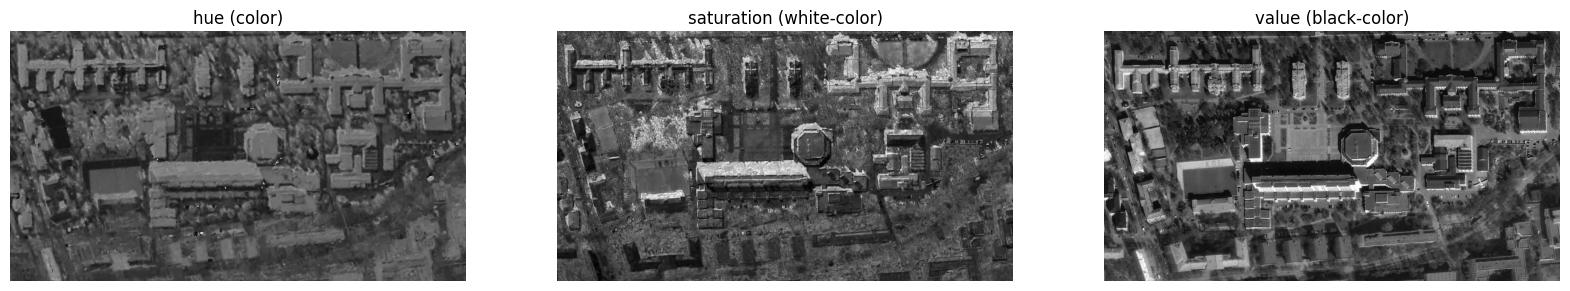

In [458]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(H, cmap='gray')
axes[0].set_title('hue (color)')
axes[0].axis('off')

axes[1].imshow(S, cmap='gray')
axes[1].set_title('saturation (white-color)')
axes[1].axis('off')

axes[2].imshow(V, cmap='gray')
axes[2].set_title('value (black-color)')
axes[2].axis('off')

(np.float64(-0.5), np.float64(1489.5), np.float64(815.5), np.float64(-0.5))

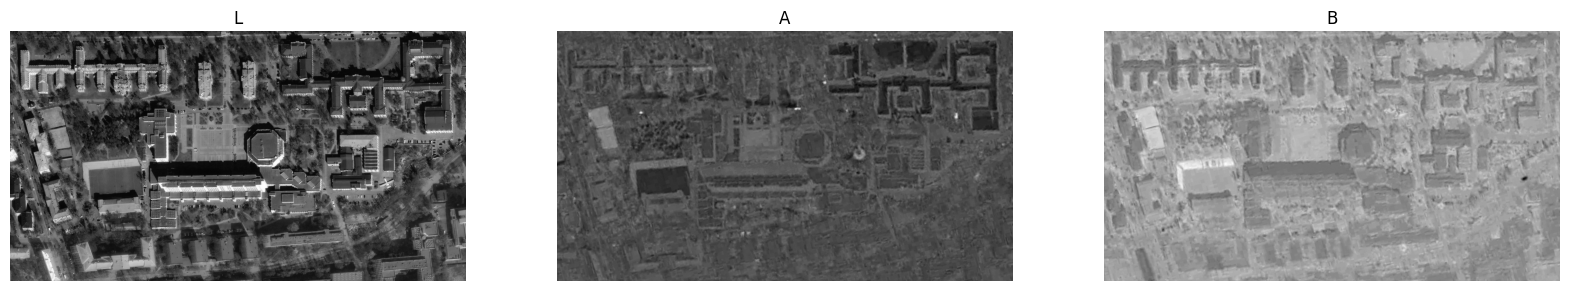

In [459]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(L, cmap='gray')
axes[0].set_title('L')
axes[0].axis('off')

axes[1].imshow(A, cmap='gray')
axes[1].set_title('A')
axes[1].axis('off')

axes[2].imshow(B, cmap='gray')
axes[2].set_title('B')
axes[2].axis('off')

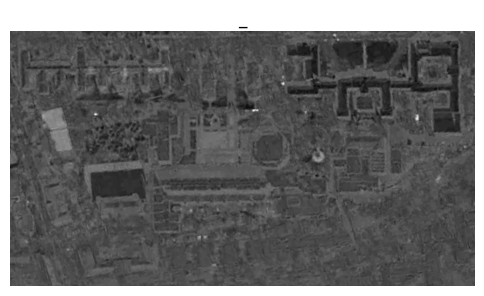

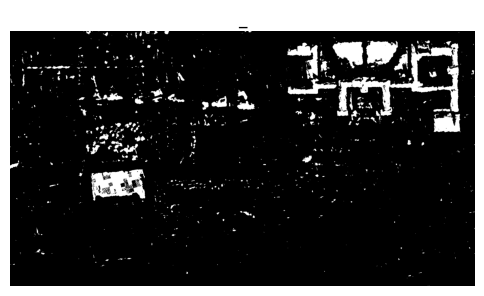

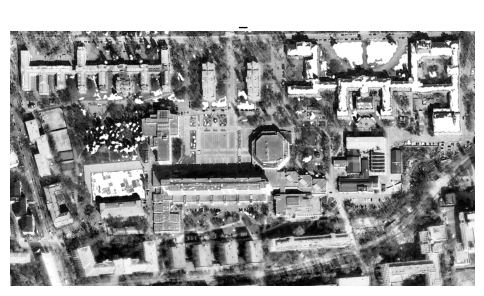

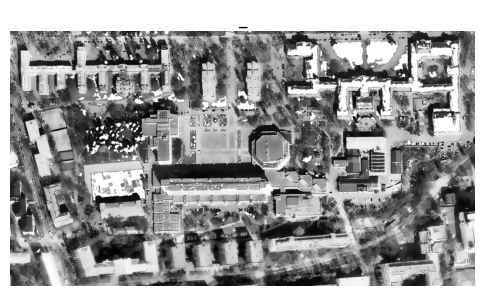

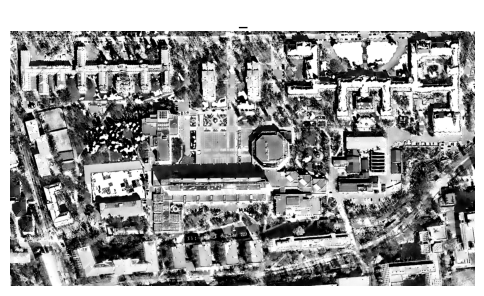

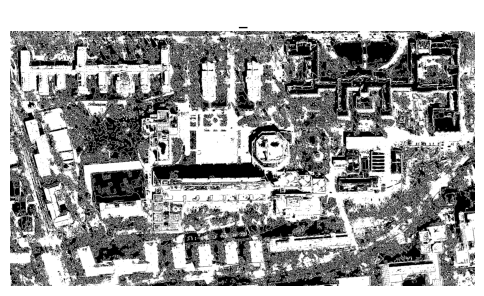

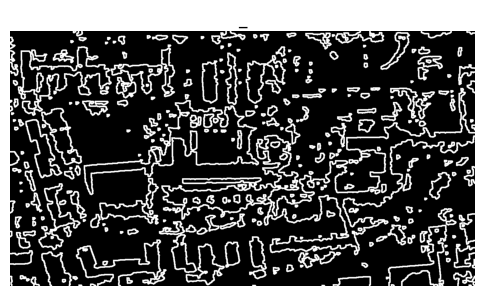

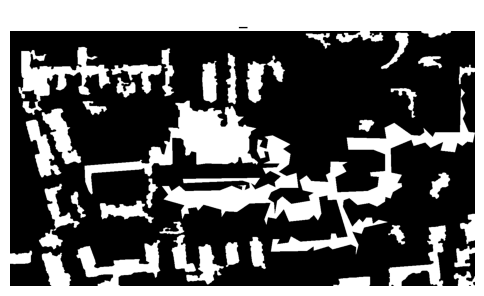

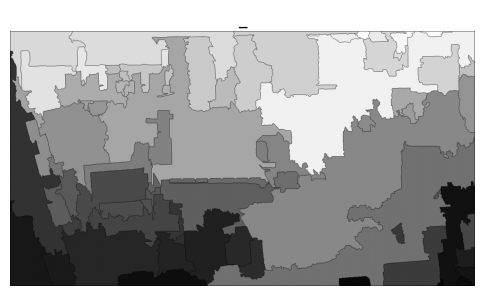

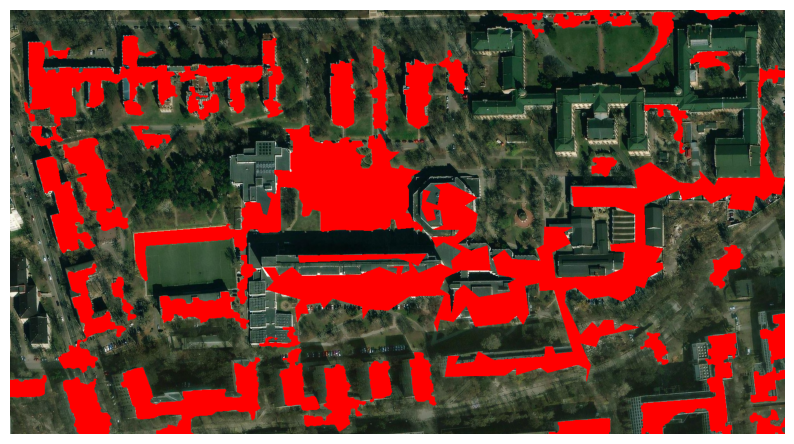

In [487]:
a_norm = cv2.normalize(A, None, 0, 255, cv2.NORM_MINMAX)
show_image(a_norm)

a_mask = cv2.inRange(a_norm, 0, 50)
show_image(a_mask)

#putting S here finds buildings' shadows
#putting H also does that??

#so i added in the green roof
L_eq = clahe.apply(cv2.add(cv2.add(cv2.multiply(L, 1), cv2.multiply(H, 0.5)), cv2.multiply(a_mask, 1)))
#L_eq = clahe.apply(L)
norm = cv2.normalize(L_eq, None, 0, 255, cv2.NORM_MINMAX)
show_image(L_eq)

blur = cv2.bilateralFilter(norm, 20, 20, 100)
show_image(blur)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, kernel)
enhanced = cv2.add(cv2.subtract(cv2.add(blur, tophat), blackhat), 0)
edges = cv2.Canny(enhanced, 50, 150)
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# min_contour_area = 65
# large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
# bing_cp = bing.copy()
# cv2.drawContours(bing_cp, large_contours, -1, (0, 255, 0), -1)
show_image(enhanced)

_, th_L = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

mask_green = cv2.inRange(hsv, (35, 60, 40), (75, 255, 255))

mask_buildings = cv2.bitwise_and(th_L, cv2.bitwise_not(mask_green))
mask_combined = cv2.bitwise_or(mask_buildings, edges)
show_image(mask_combined)

kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
opened = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel2)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel2)
gradient = cv2.morphologyEx(closed, cv2.MORPH_GRADIENT, kernel2)
show_image(gradient)

contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_contours = np.zeros_like(closed)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 1000 < area < 200000:
        approx = cv2.approxPolyDP(cnt, 0.001 * cv2.arcLength(cnt, True), True)
        cv2.drawContours(mask_contours, [approx], -1, 255, -1)
show_image(mask_contours)

dist = cv2.distanceTransform(mask_contours, cv2.DIST_L2, 5)
_, dist_thresh = cv2.threshold(dist, 0.1 * dist.max(), 255, 0)
dist_8u = np.uint8(dist_thresh)
cnts, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
markers = np.zeros(dist_8u.shape, dtype=np.int32)

for i, c in enumerate(cnts):
    cv2.drawContours(markers, [c], -1, i+1, -1)
markers = cv2.watershed(bing, markers)
show_image(markers)

overlay = bing.copy()
overlay[mask_contours > 0] = [255, 0, 0]
plt.figure(figsize=(10,10))
plt.imshow(overlay)
plt.axis('off')
plt.show()

this performes better than script in the last assignment, although it still has issues like detecting sidewalks and skipping the green roof in the right top corner. will try it on the other image:

In [443]:
lab = cv2.cvtColor(ua_map, cv2.COLOR_RGB2LAB)
hsv = cv2.cvtColor(ua_map, cv2.COLOR_RGB2HSV)
rycrcb = cv2.cvtColor(ua_map, cv2.COLOR_RGB2YCR_CB)
L, A, B = cv2.split(lab)
H, S, V = cv2.split(hsv)
Y, CR, CB = cv2.split(rycrcb)
clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(2,8))

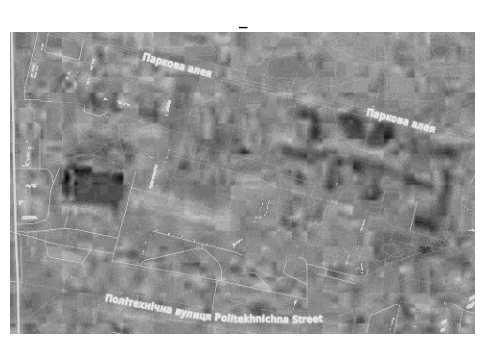

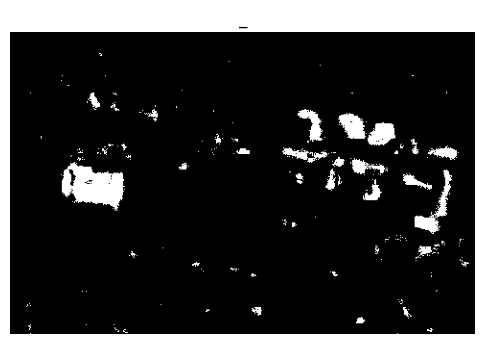

In [444]:
a_norm = cv2.normalize(A, None, 0, 255, cv2.NORM_MINMAX)
show_image(a_norm)

a_mask = cv2.inRange(a_norm, 0, 90)
show_image(a_mask)

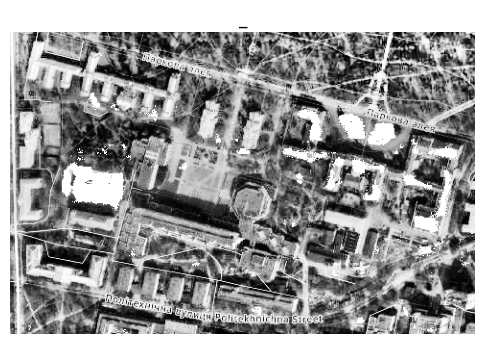

In [445]:
#putting S here finds buildings' shadows
#putting H also does that??

#so i added in the green roof
L_eq = clahe.apply(cv2.add(cv2.add(cv2.multiply(L, 1), cv2.multiply(H, 0)), cv2.multiply(a_mask, 1)))
#L_eq = clahe.apply(L)
norm = cv2.normalize(L_eq, None, 0, 255, cv2.NORM_MINMAX)
show_image(L_eq)

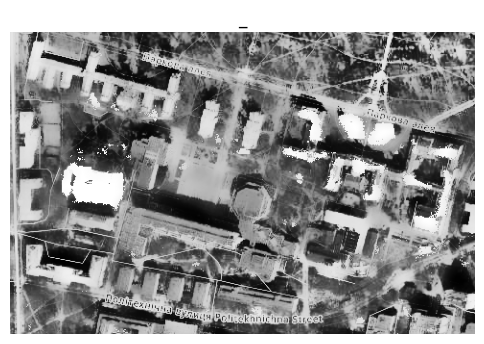

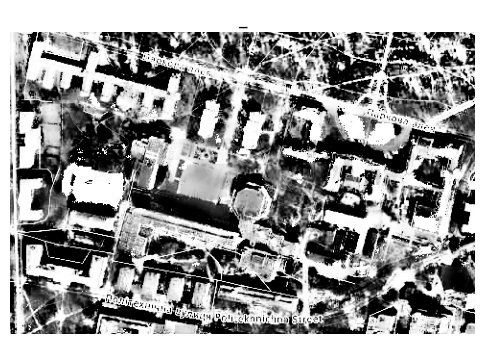

In [446]:
blur = cv2.bilateralFilter(norm, 20, 50, 100)
show_image(blur)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))
tophat = cv2.morphologyEx(blur, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, kernel)
enhanced = cv2.add(cv2.subtract(cv2.add(blur, tophat), blackhat), 0)
edges = cv2.Canny(enhanced, 30, 100)
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
show_image(enhanced)

(np.float64(-0.5), np.float64(484.5), np.float64(314.5), np.float64(-0.5))

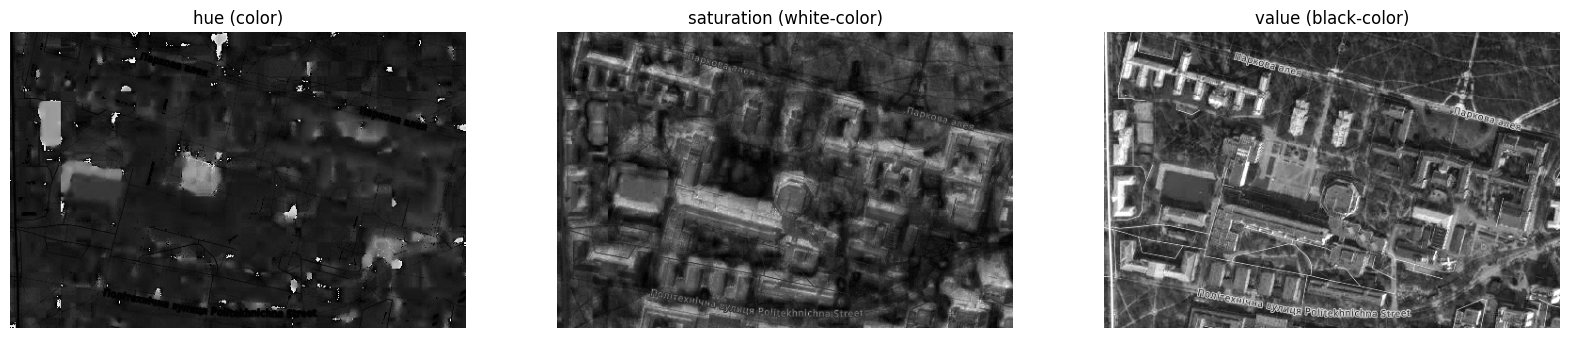

In [447]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(H, cmap='gray')
axes[0].set_title('hue (color)')
axes[0].axis('off')

axes[1].imshow(S, cmap='gray')
axes[1].set_title('saturation (white-color)')
axes[1].axis('off')

axes[2].imshow(V, cmap='gray')
axes[2].set_title('value (black-color)')
axes[2].axis('off')

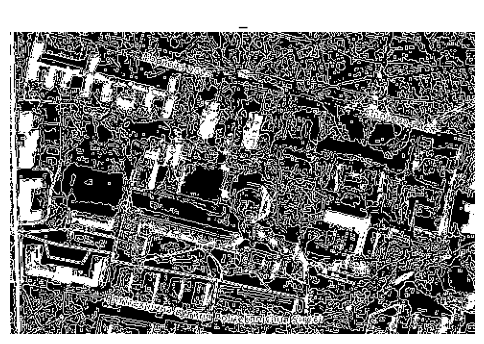

In [448]:
_, th_L = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

mask_green = cv2.inRange(hsv, (0, 0, 0), (150, 255, 150))
mask_fields = cv2.inRange(hsv, (50, 0, 0), (255, 255, 255))

mask_fields_removed = cv2.bitwise_and(th_L, cv2.bitwise_not(mask_fields))
mask_green_removed = cv2.bitwise_and(mask_fields_removed, cv2.bitwise_not(mask_green))
mask_buildings = cv2.bitwise_and(th_L, mask_green_removed)

mask_combined = cv2.bitwise_or(mask_buildings, edges)
show_image(mask_combined)

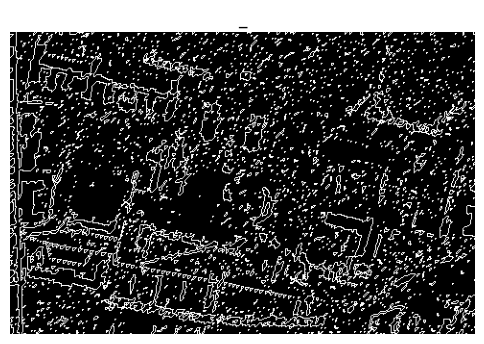

In [449]:
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
opened = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel2)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel2)
gradient = cv2.morphologyEx(closed, cv2.MORPH_GRADIENT, kernel2)
show_image(gradient)

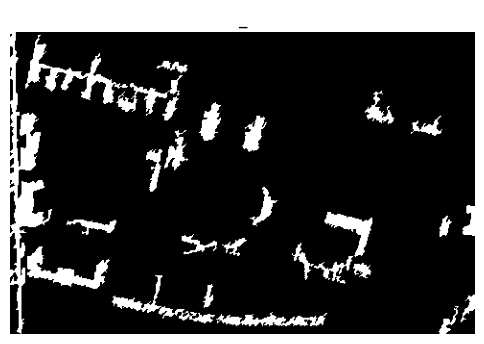

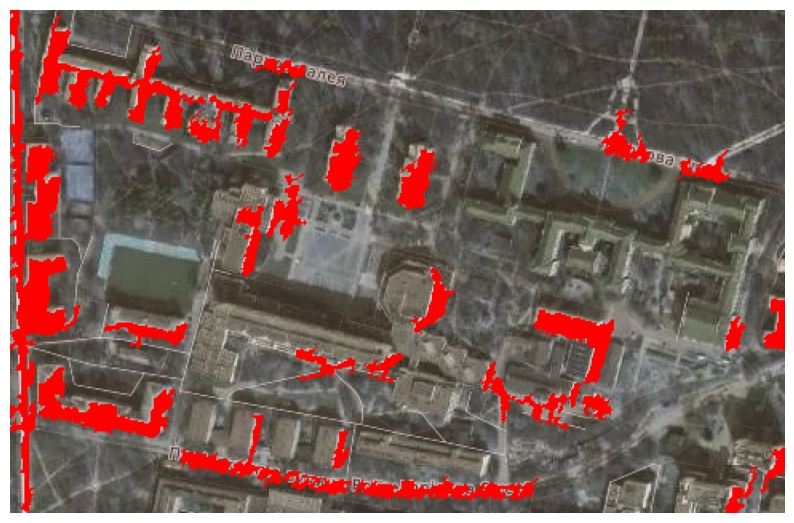

In [450]:
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_contours = np.zeros_like(closed)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if 100 < area < 200000:
        approx = cv2.approxPolyDP(cnt, 0.001 * cv2.arcLength(cnt, True), True)
        cv2.drawContours(mask_contours, [approx], -1, 255, -1)
show_image(mask_contours)

dist = cv2.distanceTransform(mask_contours, cv2.DIST_L2, 5)
_, dist_thresh = cv2.threshold(dist, 0.2 * dist.max(), 255, 0)
dist_8u = np.uint8(dist_thresh)
cnts, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
markers = np.zeros(dist_8u.shape, dtype=np.int32)

for i, c in enumerate(cnts):
    cv2.drawContours(markers, [c], -1, i+1, -1)
markers = cv2.watershed(ua_map, markers)
#show_image(markers)

overlay = ua_map.copy()
overlay[mask_contours > 0] = [255, 0, 0]
plt.figure(figsize=(10,10))
plt.imshow(overlay)
plt.axis('off')
plt.show()

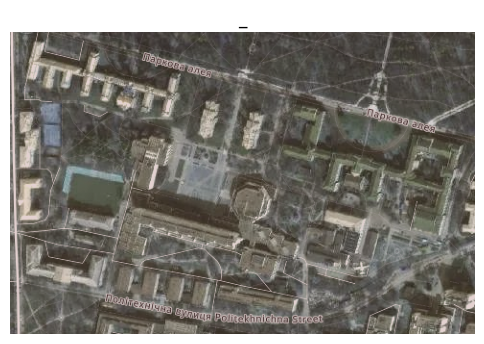

In [451]:
show_image(ua_map)